# Accumulation 

Here we visualize the accumulation results from EMY/KMR modeling results. We also test various acccumulation functions and evaluate their performance in recreating the KMR/EMY accumulation curve. 

__Simple Model__: 

Following Gilbert et al. 2020 (which is a simplified version of the accumulation function from Huss and Hocks, 2015) we first attempt to model the accumulation as: 

\begin{equation}
     A_{\rm snow}(z) = \sum^{365}_{d=1} 
    \begin{cases}
    \frac{P_{\rm ref}}{365} +( 1 +  (z-z_{\rm ref})) \frac{d P}{d z} & \text{if } T(d,z) < T_{\rm snow} ,\\
    0 & \text{if } T(d,z) \geq T_{\rm snow} ,
    \end{cases}
\end{equation}

where:
 - $P_{\rm ref}$ is mean annual precipitation at reference elevation $z_{\rm ref}$  ( kg m$^{-2}$  a$^{-1}$ ) 
 - $\frac{d P}{d z}$ Precipitation lapse rate   ( m$^{-1}$ )
 - $T_{\rm snow} = 1 ^\circ C$  snow versus rain temperature threshold  


__Piece-wise Model__: 

Given the simple model's inability to recreate the EMY/KMR accumulation curve we also test a piece-wise linear model of the form: 

\begin{equation}
    A_{\rm snow}(z) = 
    \begin{cases}
    A_{\rm max} & \text{if } z_{\rm max} < z\\
    \left( \frac{dP}{dz} \right)_{\rm a} z + b_{\rm a} & \text{if } z_{\rm ELA} < z < z_{\rm max} \\
    \left( \frac{dP}{dz} \right)_{\rm b} z + b_{\rm b} & \text{if } z < z_{\rm ELA} 
    \end{cases}
\end{equation}

The proposed model is a picewise (about the ELA) linear function, with a constant accumulation above a threshold value. All parameters are free, and the ELA is the implicity modeled ELA. 

In [125]:
import PDD
import theano
import numpy as np
import pymc3 as pm 
import arviz as az
import xarray as xr
from numpy import random
from scipy import interpolate
from scipy import linalg as LA
import matplotlib.pyplot as plt 

# theano.config.compute_test_value='raise'

plt.rcParams.update({'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w', 
                     'savefig.bbox':'tight'})

__Load the NetCDF with Kaskawulsh Data__: 

In [2]:
nc_fp = "../MB_tune/notebooks/Young_etal_2020_Delta_T_-0.9_C.nc"

with xr.open_dataset(nc_fp) as MB_new: 
    # Create a precipitation variable
    MB_new["Precip"] = MB_new.Accumulation + MB_new.Rain
    # Calculate mean annual precipsss
    P_mean = float(MB_new["Precip"].mean())
    # Calculate mean annual air temp 
    T_mean = float(MB_new["temp"].mean())

__Visualize the Precipitation__: 

Text(0.5, 0, 'Elevation m a.s.l.')

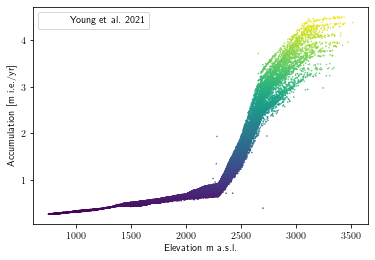

In [3]:
fig, ax = plt.subplots()

ax.scatter(MB_new.Elevation, 
           MB_new.Accumulation,
           c=MB_new.Accumulation,
           s=0.25,
           label='Young et al. 2021')

ax.legend()
ax.set_ylabel('Accumulation [m i.e./yr]')
ax.set_xlabel('Elevation m a.s.l.')

__Collpase distributed arrays along Elevation:__

In [4]:
stacked  = MB_new.stack(z=('x','y'))

# Calculate the Kaskawulsh ELA 
ELA_idxs = np.argpartition(np.abs(stacked.MB.values), 5)
z_ELA    = float(stacked.isel(z=ELA_idxs[:5]).Elevation.mean())

# Collapse the data along a new (sorted) axis: elevation 
idxs = stacked.dropna('z').z.values
elev = stacked.Elevation.dropna('z').values
idxs = idxs[np.argsort(elev)]
ds_sort = stacked.sel(z=idxs)

__Simple Model Fitting__: 

In [ ]:
# dictionary of PDD model parameters
const =  dict(T_m   = 0.0,
              T_rs   = 1.0,
              A_mean = P_mean * 910., 
              α      = 10.5, 
              T_ma   = T_mean,
              ΔTΔz   = 6.5E-3, 
              T_p    = 196,
              T_σ    = 8.6,
              ref_z  = 2193)

# initialize the PDD melt model class
Accum_def = PDD.Accumulation_default(**const)

MCMC model fitting: 

In [ ]:
# Define Priors
with pm.Model() as model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Need a reference for the accumulation grad distibution 
    grad_a     = pm.Uniform("grad_a", lower=0.5e-4, upper=5e-4)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma      = pm.HalfCauchy("sigma", 10)    


# Define Forward model (wrapped through theano)
with model: 
    A_snow = Accum_def.tt_forward(ds_sort.Elevation.values[::10], grad_a)
    

# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=A_snow, sigma=sigma, observed=ds_sort.Accumulation.values[::10])
    
# run inference: Sample   
with model: 

    # obtain starting values via MAP
#     startvals = pm.find_MAP() 
    
    trace = pm.sample(#start=startvals,
                      draws=2000, 
                      tune=2000, 
                      cores=2, 
                      return_inferencedata=True);
    
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["grad_a", "sigma"])

In [ ]:
fig, ax = plt.subplots()

ax.scatter(ds_sort.Elevation.values, 
           ds_sort.Accumulation.values, s=0.5)

for i, j in enumerate(np.random.randint(0,3999,499)):
    grad_a = ppc["grad_a"][j]        
    
    A = Accum_def.eval_forward(ds_sort.Elevation.values[::10], grad_a)
    
    ax.plot(ds_sort.Elevation.values[::10], A, c='tab:orange', alpha=0.5)
    
plt.savefig('/Users/andrewnolan/Desktop/MCMC_Accum.png', dpi=300)

In [5]:
from scipy import optimize


class Accum_default:

    def __init__(self, z, P_obs, α, T_ma, ΔTΔz, T_p, ref_z, T_m, T_rs, T_σ, A_mean):
        self.z      = z
        self.P_obs  = P_obs
        self.α      = α       # anual air temp. amplitude    [K]
        self.T_ma   = T_ma    # Mean annual air temp @ ref_z [K]
        self.ΔTΔz   = ΔTΔz    # air temp lapse rate          [K m^-1]
        self.T_p    = T_p     # DOY of annual temp peak      [DOY]
        self.ref_z  = ref_z   # reference surface elevation  [m a.s.l.]
        self.T_m    = T_m     # Melting temp. threshold      [K]
        self.T_rs   = T_rs    # T_
        self.T_σ    = T_σ
        self.A_mean = A_mean  # Mean annual accum.   @ ref_z [kg m^-2 yr^-1]

    def __air_temp(self):
        """"Evaluate the surface air temperature at a given evlevation for a given
            day of the year

        Inputs:
            z   (float or Nx1 ndarry) ---> Nodal surface elevation [m a.s.l.]

        Outputs:
            T   (floar or Nx365 ndarray) ---> Nodal surface elevation for each
                                              day of the yeat      [C]
        """
        doy  = np.arange(1,366)[:, np.newaxis]
        Temp = self.α*np.cos( 2*np.pi*(doy-self.T_p)/365 ) + \
               self.ΔTΔz*(self.ref_z-self.z)+self.T_ma + \
               np.random.normal(0, self.T_σ, (365,1))

        return Temp

    def forward(self, ΔPΔz):
        T     = self.__air_temp() #+ T_bias

        PDDs = np.where(T > self.T_m, T, 0.0).sum(axis=0)

        accum_days = np.where(T < self.T_rs, 1/365., 0.0).sum(axis=0)

        # calculate snow accumulation
        A_snow = np.maximum((accum_days*self.A_mean)* (1+(self.z-self.ref_z)*ΔPΔz),
                            0.0)
        return A_snow * (1/910)

    def __cost(self, p): 
        return self.forward(p) - self.P_obs

    def fit(self, p0, loss='soft_l1'): 
        res_lsq = optimize.least_squares(self.__cost, p0, loss=loss)
        return res_lsq

In [179]:
class Accum_piece:

    def __init__(self, z, P_obs, z_ELA):
        self.z      = z
        self.P_obs  = P_obs
        self.z_ELA  = z_ELA   # ELA elevation (known a prior only in the test case)

#     def forward(self, z, z_max, P0, ΔPΔz_1, ΔPΔz_2, P_max):
#         accum = np.piecewise(z, 
#                              [z < self.z_ELA, 
#                               (self.z_ELA < z) & (z < z_max), 
#                               z_max < z], 
#                              [lambda z:ΔPΔz_1*z + P0-ΔPΔz_1*self.z_ELA, 
#                               lambda z:ΔPΔz_2*z + P0-ΔPΔz_2*self.z_ELA, 
#                               P_max])
#         return accum

    def forward(z, z_max, P0, ΔPΔz_1, ΔPΔz_2, P_max):
        accum = np.piecewise(z, 
                             [z < z_ELA, (z_ELA < z) & (z < z_max), z_max < z], 
                             [lambda z:ΔPΔz_1*z + P0-ΔPΔz_1*z_ELA, 
                              lambda z:ΔPΔz_2*z + P0-ΔPΔz_2*z_ELA, 
                              P_max])
        return accum
    
#     def forward(self, x, x1, k1, k2, k3):
#         x = ds_sort.Elevation.values[::10]
#         x0 = self.z_ELA
#         y0 = 0.6
# #         print(y0)
#         return np.piecewise(x, [x < x0, (x0 < x) & (x < x1), x1 < x], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0, k3])


    def __cost(self, p): 
        return self.forward(*p) - self.P_obs

    def fit(self, p0, loss='linear'): 
#         res_lsq = optimize.least_squares(self.__cost, p0, loss=loss)
        p, cov = optimize.curve_fit(forward, self.z, self.P_obs, p0=p0, args=(self.z_ELA))
        return p

In [180]:
# dictionary of PDD model parameters
const =  dict(z      = ds_sort.Elevation.values[::10],
              P_obs  = ds_sort.Precip.values[::10],
              T_m    = 0.0,
              T_rs   = 1.0,
              A_mean = P_mean * 910., 
              α      = 10.5, 
              T_ma   = T_mean,
              ΔTΔz   = 6.5E-3, 
              T_p    = 196,
              T_σ    = 8.6,
              ref_z  = 2193)

# initialize the PDD melt model class
default   = Accum_default(**const)
def_lstq  = default.fit(p0=[5e-4])
def_pred  = default.forward(def_lstq.x)

In [183]:
def forward(z, z_max, P0, ΔPΔz_1, ΔPΔz_2, P_max):
    z_ELA = 2226
    accum = np.piecewise(z, 
                         [z < z_ELA, (z_ELA < z) & (z < z_max), z_max < z], 
                         [lambda z:ΔPΔz_1*z + P0-ΔPΔz_1*z_ELA, 
                          lambda z:ΔPΔz_2*z + P0-ΔPΔz_2*z_ELA, 
                          P_max])
    return accum

p , e = optimize.curve_fit(forward, 
                           ds_sort.Elevation.values[::10], 
                           ds_sort.Accumulation.values[::10],
                           p0=[3070, 0.0, 10e-4, 10e-3, 4.2])

In [184]:
# dictionary of PDD model parameters
const =  dict(z     = ds_sort.Elevation.values[::10],
              P_obs = ds_sort.Precip.values[::10],
              z_ELA = z_ELA)

# # initialize the PDD melt model class
# piece      = Accum_piece(**const)
# piece_lstq = piece.fit(p0=[3100, -10.0, 10e-4, 10e-3, 4.1],  loss='linear')
# piece_pred = piece.forward(*piece_lstq)
piece_pred = forward(*p)

ValueError: 'args' is not a supported keyword argument.

In [162]:
piece_lstq

array([3.10000000e+03, 7.18916879e-01, 3.94707211e-05, 3.95339067e-03,
       4.02148938e+00])

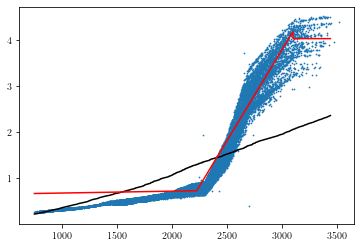

In [163]:
plt.scatter(ds_sort.Elevation.values, 
            ds_sort.Accumulation.values, s=0.5)

plt.plot(default.z, def_pred, c='k')
plt.plot(piece.z,   piece_pred, c='r')

__Piecewise Linear Function:__

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
theano.config.compute_test_value = 'warn'

# dictionary of PDD model parameters
const =  dict(z_ELA = z_ELA)

# initialize the PDD melt model class
Piece_def = PDD.Accumulation_piecewise(**const)

In [ ]:
# Define Priors
with pm.Model() as model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Need a reference for the accumulation grad distibution 
    z_max_prior  = pm.Uniform("z_max",  lower=3000, upper=3500)
    P0_prior     = pm.Uniform("P0",     lower=0.0, upper=1.0)
    ΔPΔz_1_prior = pm.Uniform("ΔPΔz_1", lower=0.5e-4, upper=5e-4)
    ΔPΔz_2_prior = pm.Uniform("ΔPΔz_2", lower=0.5e-3, upper=5e-3)
    P_max_prior  = pm.Uniform("P_max",  lower=3.5, upper=4.5)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma      = pm.HalfCauchy("sigma", 10)    


# Define Forward model (wrapped through theano)
with model: 
    A_snow = Piece_def.tt_forward(ds_sort.Elevation.values[::10], 
                                  z_max_prior, P0_prior, ΔPΔz_1_prior, 
                                  ΔPΔz_2_prior, P_max_prior)
    

# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=A_snow, sigma=sigma, observed=ds_sort.Accumulation.values[::10])
    
# run inference: Sample   
with model: 

    # obtain starting values via MAP
#     startvals = pm.find_MAP() 
    
    trace = pm.sample(#start=startvals,
                      draws=2000, 
                      tune=2000, 
                      cores=2, 
                      return_inferencedata=True);
    
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["z_max", "P0", "ΔPΔz_1", "ΔPΔz_2", "P_max"])

In [ ]:
fig, ax = plt.subplots()

ax.scatter(ds_sort.Elevation.values, 
           ds_sort.Accumulation.values, s=0.5)

for i, j in enumerate(np.random.randint(0,3999,499)):
    grad_a = ppc["grad_a"][j]        
    
    A = Accum_def.eval_forward(ds_sort.Elevation.values[::10], grad_a)
    
    ax.plot(ds_sort.Elevation.values[::10], A, c='tab:orange', alpha=0.5)
    
# plt.savefig('/Users/andrewnolan/Desktop/MCMC_Accum.png', dpi=300)